### WindExpositionsindex (WEI)

**Datenquelle:** Rasterdaten der 10-m-Windgeschwindigkeit **si10** (monatliche Mittel, NetCDF, Copernicus).  
**Zeitraum:** Jahresmittel über drei Jahre

**Grundgröße je Gemeinde $g$ und Jahr $y$:**
- $ \mathrm{si10}_{g,y} $: flächengewichtetes Mittel der 10-m-Windgeschwindigkeit (m/s) über pro Monat (Jan-Dez).

**Jahresfenster-Mittelwerte (über $Y=\{y_1,\dots,y_k\}$):**
$$
\overline{\mathrm{si10}}_g \;=\; \frac{1}{|Y|}\sum_{y\in Y} \mathrm{si10}_{g,y}.
$$

**Robuste Standardisierung über alle Gemeinden $g\in G$:**
$$
z_r(x_g) \;=\; \frac{x_g - \operatorname{median}_{h\in G}(x_h)}
{1.4826 \cdot \operatorname{median}_{h\in G}\!\bigl(|x_h - \operatorname{median}_{j\in G}(x_j)|\bigr)}.
$$
*(Optional: $z_r$ bei $\pm 3$ winsorizen.)*

**Index (roh):**
$$
\mathrm{WEI}_{\text{raw}}(g) \;=\; z_r\!\bigl(\overline{\mathrm{si10}}_g\bigr).
$$

**Robustes 0–100-Scaling (p1/p99-Clipping):**
$$
p_1 = \operatorname{perc}_{1\%}\!\bigl(\mathrm{WEI}_{\text{raw}}(h)\bigr),\quad
p_{99} = \operatorname{perc}_{99\%}\!\bigl(\mathrm{WEI}_{\text{raw}}(h)\bigr),
$$
$$
\mathrm{WEI}(g) \;=\; 100 \cdot 
\min\!\left\{1,\ \max\!\left\{0,\ \frac{\mathrm{WEI}_{\text{raw}}(g) - p_1}{\,p_{99} - p_1\,}\right\}\right\}.
$$

**Interpretation:** Hoher WEI ⇒ **windreiche/exponierte** Lagen (offenes Gelände, Küsten, Kämme).  
Niedriger WEI ⇒ **windarme/geschützte** Lagen (Täler, Abschattung).


In [1]:
from rasterstats import zonal_stats
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio.enums import Resampling

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm

import choropleth_pipeline as cp


In [8]:
def load_si10_monthly(path_nc: str, var_name: str | None = None):
    import numpy as np
    import pandas as pd
    import xarray as xr
    import rioxarray  # noqa: F401

    ds = xr.open_dataset(path_nc, decode_times=True, mask_and_scale=True)

    # Variable wählen
    if not var_name or var_name not in ds.data_vars:
        cands = [k for k in ds.data_vars if "si10" in k.lower() or "wind" in k.lower()]
        var_name = cands[0] if cands else list(ds.data_vars)[0]
    da = ds[var_name]

    # Zeitachse vereinheitlichen
    tname = next((n for n in list(da.dims)+list(da.coords) if "time" in n.lower()), None)
    if not tname:
        raise ValueError("Keine Zeitdimension gefunden.")
    t = pd.to_datetime(da[tname].values)
    da = da.assign_coords({tname: t})

    # Einheiten -> m/s
    units = (da.attrs.get("units", "") or "").lower().replace(" ", "")
    factor = 1.0
    if "km/h" in units or "kmh" in units:
        factor = 1/3.6
    elif "knot" in units or "kt" in units:
        factor = 0.514444
    da = da.astype("float32") * np.float32(factor)
    da.attrs["units"] = "m/s"
    da.name = "si10_ms"

    # Raumachsen bestimmen
    lat_name = next((n for n in list(da.dims)+list(da.coords) if n.lower() in {"lat","latitude","y"}), None)
    lon_name = next((n for n in list(da.dims)+list(da.coords) if n.lower() in {"lon","longitude","x"}), None)
    if not lat_name or not lon_name:
        raise ValueError("Lat/Lon-Koordinaten nicht gefunden.")

    # Lon 0..360 -> -180..180
    try:
        lon_vals = da[lon_name].values
        if np.nanmax(lon_vals) > 180:
            da = da.assign_coords({lon_name: ((lon_vals + 180) % 360) - 180}).sortby(lon_name)
    except Exception:
        pass

    # Monatsmittel
    da_m = da.resample(**{tname: "MS"}).mean(skipna=True).rename({tname: "valid_time"})

    # rioxarray: Spatial dims setzen (positional!), CRS schreiben
    da_m = da_m.rio.set_spatial_dims(lon_name, lat_name, inplace=False)
    if not getattr(da_m.rio, "crs", None):
        da_m = da_m.rio.write_crs(4326)

    return da_m


def compute_wind_exposure(
    da_si10, gdf, years, window=3, id_col="AGS",
    dst_crs="EPSG:3035", require_full_year=True,
    all_touched=True, res_km=None, centroid_fallback=True
):
    # CRS -> Equal-area
    da = da_si10
    if not getattr(da.rio, "crs", None):
        da = da.rio.write_crs(4326)
    da = da.rio.reproject(dst_crs)

    # optional: auf feineres Raster (z.B. 5 km) bilinear resamplen
    if res_km is not None:
        da = da.rio.reproject(da.rio.crs, resolution=res_km*1000, resampling=Resampling.bilinear)

    # Jahresmittel aus Monatsmitteln
    ann = da.groupby("valid_time.year").mean("valid_time", skipna=True)

    # vollständige Jahre bestimmen
    t = pd.DatetimeIndex(da["valid_time"].values)
    full_years = set(pd.Series(1, index=t).groupby(t.year).count().pipe(lambda s: s[s>=12].index).tolist())
    have_years = set(int(y) for y in ann["year"].values)

    gm = gdf.to_crs(dst_crs).copy()
    gm[id_col] = gm[id_col].astype(str)

    def three_year_block(y):
        yrs = list(range(y - window + 1, y + 1))
        yrs = [yy for yy in yrs if (yy in (full_years if require_full_year else have_years))]
        return None if not yrs or (require_full_year and len(yrs)<window) else ann.sel(year=yrs).mean("year")

    out = []
    for y in years:
        block = three_year_block(int(y))
        if block is None:
            continue

        # 1) Zonal-Stats mit all_touched
        zs = zonal_stats(
            gm, block.values,
            affine=block.rio.transform(),
            nodata=np.nan,
            stats=["mean"],
            all_touched=all_touched
        )
        vals = np.array([z["mean"] for z in zs], dtype=float)

        # 2) Fallback: Centroid-Sampling für NaNs
        if centroid_fallback and np.isnan(vals).any():
            missing = np.isnan(vals)
            cent = gm.loc[missing].geometry.centroid
            coords = [(pt.x, pt.y) for pt in cent]
            samp = list(block.rio.sample(coords))  # list of arrays or None
            samp = np.array([s[0] if (s is not None and len(s)>0) else np.nan for s in samp], dtype=float)
            vals[missing] = samp

        out.append(pd.DataFrame({id_col: gm[id_col].values, "year": int(y), "si10_ms": vals}))

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(columns=[id_col, "year", "si10_ms"])


In [10]:
da = load_si10_monthly("../data/CopernicusGrid/Wind/wind.nc")

# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# # Geometriedaten
# gm = gpd.read_file("gemeinden_2024.gpkg")  # enthält 'ARS'

vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS") 
gm = cp.load_level(vg, "GEM")

# # Strukturelle Stichtage: 2011 und 2022; 2025 optional (evtl. unvollständig)
# wind_df = compute_wind_exposure(
#     da, gm, years=[2011, 2022, 2024],
#     window=3, id_col="AGS",
#     require_full_year=True   # auf False setzen, falls 2025 trotzdem rein soll
# )

wind_df = compute_wind_exposure(
    da, gm, years=[2021,2022,2023],
    window=3, id_col="ARS",
    require_full_year=True,
    all_touched=True,     # wichtig gegen Lücken
    res_km=5,             # optional: 5 km glättet die Abdeckung
    centroid_fallback=True
)

In [42]:
wind_df.columns

Index(['ARS', 'year', 'si10_ms'], dtype='object')

In [56]:
# mitteln über die drei Jahre
df = wind_df[wind_df['year'] == 2023].copy()
df.rename(columns = {'si10_ms':'si10_ms_2023'}, inplace = True)
df.drop(columns = 'year', inplace = True)

df22 = wind_df[wind_df['year'] == 2022].copy()
df22.rename(columns = {'si10_ms':'si10_ms_2022'}, inplace = True)
df22.drop(columns = 'year', inplace = True)

df21 = wind_df[wind_df['year'] == 2021].copy()
df21.rename(columns = {'si10_ms':'si10_ms_2021'}, inplace = True)
df21.drop(columns = 'year', inplace = True)

df =df.merge(df22, on = 'ARS', how = 'inner').merge(df21, on = 'ARS', how = 'inner')

# mean über 2020-2023
df['si10_mean'] = (df['si10_ms_2023']+df['si10_ms_2022']+df['si10_ms_2021'])/3


In [59]:
# geodataframe aus gm erzeugen (d.h. Geometrie aus Gemeinden anfügen)
wind_gdf = gm.merge(df, on = 'ARS', how = 'inner')

# übliche Problematik beim Plot, ohne Geometrie,
# gibt es einen 'Line2D.set() got an inexpected argument norm' Fehler

wind_gdf.columns

Index(['OBJID', 'BEGINN', 'ADE', 'GF', 'BSG', 'ARS', 'AGS', 'SDV_ARS', 'GEN',
       'BEZ', 'IBZ', 'BEM', 'NBD', 'SN_L', 'SN_R', 'SN_K', 'SN_V1', 'SN_V2',
       'SN_G', 'FK_S3', 'NUTS', 'ARS_0', 'AGS_0', 'WSK', 'DLM_ID', 'geometry',
       'si10_ms_2023', 'si10_ms_2022', 'si10_ms_2021', 'si10_mean'],
      dtype='object')

In [69]:
wind_gdf['si10_mean' + "_z"] = cp.robust_z(wind_gdf['si10_mean'])

# zur besseren Darstellung auf 0-100 skalieren (entspricht % Wert)
# p1, p99 = np.nanpercentile(wind_gdf["si10_mean_z"], [1, 99])
# denom = (p99 - p1) if p99 > p1 else (wind_gdf["si10_mean_z"].max() - wind_gdf["si10_mean_z"].min() or 1.0)
# wind_gdf["Index_0_100"] = ((wind_gdf["si10_mean_z"] - p1) / denom * 100).clip(0, 100)
wind_gdf["Index_0_100"] = cp.scale_0_100(wind_gdf["si10_mean_z"],1, 99)


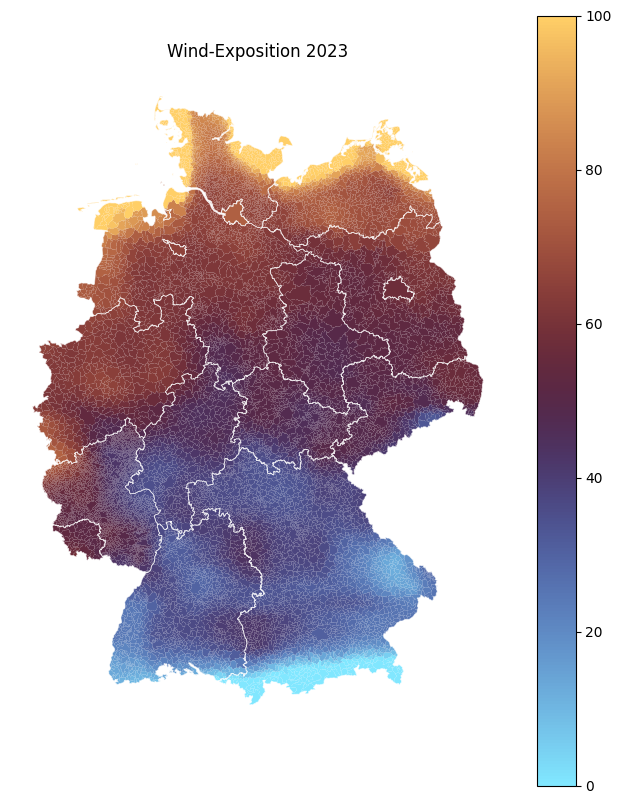

In [76]:
# spalte wählen
value_col = 'Index_0_100'

# Skala wählen (.1–99. Perzentil)
vmin, vcenter, vmax = wind_gdf[value_col].quantile([0.01, 0.5, 0.99]).tolist()

# Bundesländer (Umrisse)
laender = cp.load_level(vg, "LAN")

# plots with a view
fig, ax = cp.plot_choropleth_continuous(
    wind_gdf,
    value_col=value_col,
    cmap_name="managua_r",          
    title=f"Wind-Exposition 2023",
    laender = laender,
    figsize=(8, 10),
    norm = None #TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax) 
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"WEI_2023.png", 
    out_dir="exports",
    dpi=300
)


## Export to CSV

In [75]:
wind_gdf[['ARS','si10_ms_2023', 'si10_ms_2022', 'si10_ms_2021', 'si10_mean',
       'si10_mean_z', 'Index_0_100']].to_csv('csv/WindExposureIndex_2023.csv', index = False)

In [ ]:
col = "Index_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 4)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["ländlich (Q1)", "suburban (Q2+Q3)", "urban (Q4)"][:bins.size - 1]

# colors = cp.colors_from_mpl("BrBG", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Urbanität – Quartile",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Urbanity_index_Qs.png", 
    out_dir="exports/Zusatzkarten",
    dpi=300
)